In [1]:


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/test_features.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/train_targets_scored.csv


In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import tensorflow_addons as tfa
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from tqdm.notebook import tqdm
%matplotlib inline

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [3]:
train_features = pd.read_csv('/kaggle/input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('/kaggle/input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('/kaggle/input/lish-moa/train_targets_nonscored.csv')
test_features = pd.read_csv('/kaggle/input/lish-moa/test_features.csv')
submission = pd.read_csv('../input/lish-moa/sample_submission.csv')

In [4]:
train_features.sample(5)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
9823,id_69caf78c7,trt_cp,48,D1,-1.4240,-1.0440,-0.6256,0.1016,0.6505,-0.1603,...,0.2479,1.1780,0.7468,0.5671,1.0700,-0.0417,-0.2545,-0.2198,-0.0127,0.3100
8727,id_5e1a8b07f,trt_cp,48,D2,-0.4578,-0.0960,-0.4925,-0.4304,-0.3381,-0.1732,...,-0.8299,-0.2293,-0.5617,-0.2936,0.8751,-0.4272,0.8660,-0.4397,-0.4028,0.0300
11156,id_77dc77254,trt_cp,72,D2,0.7682,0.4978,0.0175,-0.7979,-0.7423,-0.6327,...,0.3950,0.3911,0.2941,0.1204,0.3093,-1.2270,0.1014,0.2828,0.3747,0.0925
13616,id_92b51dc6d,trt_cp,72,D1,-0.1876,-0.7545,0.5666,-0.2984,-0.0331,-2.0340,...,0.4426,0.6635,0.0766,-0.2268,0.3248,0.2884,0.9635,0.4872,0.1177,0.7663
5687,id_3d352008f,trt_cp,48,D1,-0.1901,-0.1086,-0.3145,0.7861,0.3019,0.3368,...,0.7420,0.8955,0.4949,0.3628,-0.8674,0.0712,-0.4152,-0.5144,0.2196,0.8320


In [5]:
test_features.sample(5)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
2807,id_b4513982a,trt_cp,48,D2,0.2805,-0.5958,0.3077,0.9671,0.1506,1.6180,...,-0.3610,-0.8574,-0.1740,0.1256,0.1987,-0.0449,-0.1439,-1.1380,0.4842,0.1440
2314,id_9482b7498,trt_cp,48,D2,-0.3117,-0.7720,0.3519,-0.8836,0.3874,0.1831,...,-1.1500,-1.1570,-1.3840,-0.8274,-0.5133,-0.7733,-0.8489,0.2269,0.3023,-0.0002
810,id_353f5936a,trt_cp,72,D1,-0.3076,0.7842,0.4006,0.0634,0.6630,-2.7090,...,-2.9810,-1.7470,-1.6470,-2.0410,-2.0070,-2.3380,-0.8528,0.0069,-1.1070,-3.0320
3046,id_c4caa1425,trt_cp,48,D1,0.0801,0.7271,0.8008,1.2800,0.6220,-1.3930,...,0.5089,-0.2979,0.5306,1.2200,-0.2563,1.0340,-0.1661,-0.4246,0.7535,1.1040
883,id_39e6da485,trt_cp,24,D2,2.9160,1.5180,-0.0300,1.9680,1.4910,-0.0384,...,-8.4320,-6.3420,-7.0010,-9.4210,-8.0310,-2.3690,-5.4910,-4.8200,-3.6770,-2.1450


In [6]:
train_targets_scored.sample(5)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
275,id_02d9e7c10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16140,id_ad97a0909,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
369,id_03ee99eeb,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4224,id_2d636f5e4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18238,id_c3b9f4f5f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
train_features['dataset'] = 'train'
test_features['dataset'] = 'test'

df = pd.concat([train_features, test_features])

ds = df.groupby(['cp_type', 'dataset'])['sig_id'].count().reset_index()
ds.columns = ['cp_type', 'dataset', 'count']

fig = px.bar(
    ds, 
    x='cp_type', 
    y="count", 
    color = 'dataset',
    barmode='group',
    orientation='v', 
    title='cp_type train/test counts', 
    width=500,
    height=400
)

fig.show()

In [8]:
ds = df.groupby(['cp_time', 'dataset'])['sig_id'].count().reset_index()
ds.columns = ['cp_time', 'dataset', 'count']

fig = px.bar(
    ds, 
    x='cp_time', 
    y="count", 
    color = 'dataset',
    barmode='group',
    orientation='v', 
    title='cp_time train/test counts', 
    width=500,
    height=400
)

fig.show()

In [9]:
ds = df.groupby(['cp_dose', 'dataset'])['sig_id'].count().reset_index()
ds.columns = ['cp_dose', 'dataset', 'count']

fig = px.bar(
    ds, 
    x='cp_dose', 
    y="count", 
    color = 'dataset',
    barmode='group',
    orientation='v', 
    title='cp_dose train/test counts', 
    width=500,
    height=400
)

fig.show()

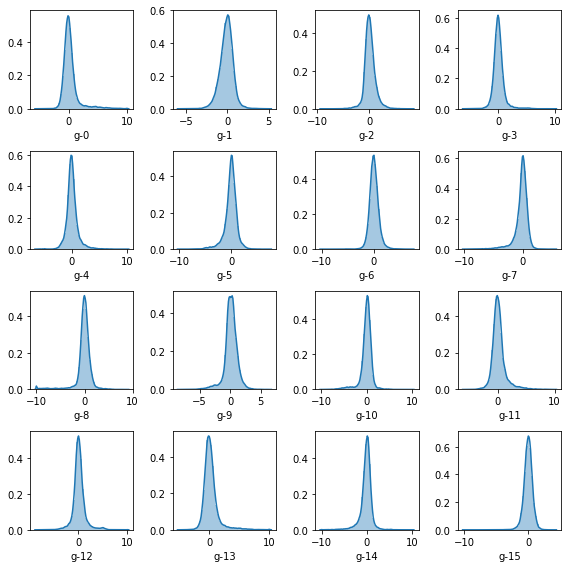

In [10]:
#gene data distribution
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, column in enumerate(train_features[train_features.columns[4:20]].columns):
    sns.distplot(train_features[column], ax=axes[i // 4, i % 4])
plt.tight_layout()
plt.show()

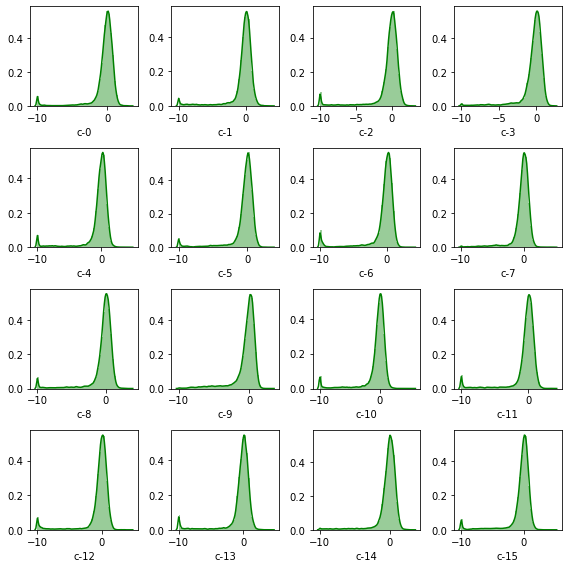

In [11]:
#cell data distribution
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, column in enumerate(train_features[train_features.columns[776:792]].columns):
    sns.distplot(train_features[column], ax=axes[i // 4, i % 4], color='green')
plt.tight_layout()
plt.show()

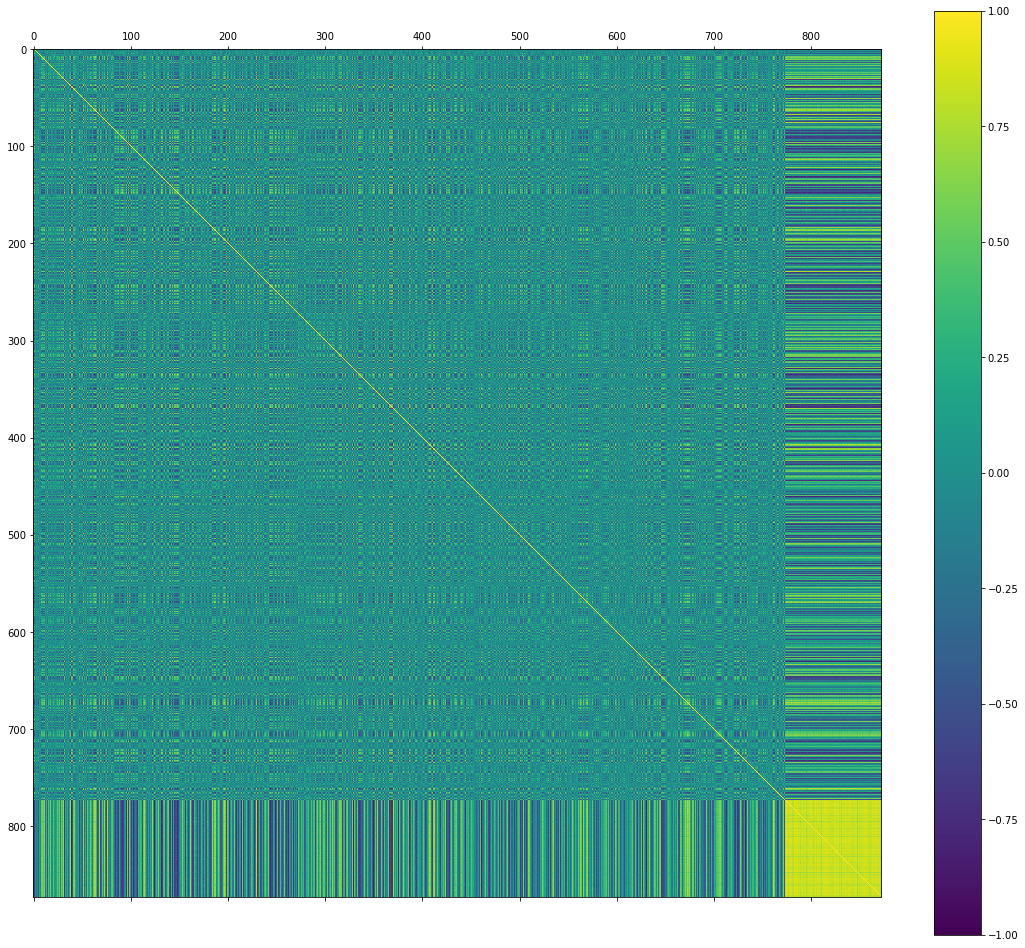

In [12]:
correlations = train_features.corr()
# plot correlation matrix
fig = plt.figure(figsize=(19, 17))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

In [13]:
correlations.sample(5)

,cp_time,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
g-119,0.009654,-0.097317,0.136301,-0.143228,-0.206148,0.100933,0.054361,0.116179,0.383807,0.172723,...,0.235782,0.232919,0.250124,0.237152,0.252383,0.219332,0.268312,0.260064,0.278654,0.213027
g-743,0.037315,-0.469595,0.088382,-0.113000,-0.140391,-0.291644,-0.038668,-0.172432,0.312580,0.529220,...,0.456718,0.503928,0.421694,0.507104,0.458825,0.443462,0.480866,0.445744,0.504993,0.450528
g-26,-0.046168,-0.422814,-0.019435,-0.126554,0.111355,-0.340708,0.058257,-0.194962,0.262002,0.384568,...,0.548274,0.536828,0.531453,0.539956,0.552518,0.518623,0.544908,0.531780,0.517023,0.505357
g-254,-0.067340,0.234474,0.004241,0.001167,0.155810,0.156479,-0.023310,0.159865,-0.341567,-0.078279,...,-0.333365,-0.248111,-0.348630,-0.333853,-0.324161,-0.166556,-0.288765,-0.273228,-0.230701,-0.213235
g-195,-0.017030,-0.613026,0.061442,-0.200651,-0.219825,-0.273896,0.094598,-0.149138,0.702811,0.532056,...,0.748188,0.732936,0.743585,0.753689,0.757246,0.675717,0.749211,0.733774,0.708802,0.673849


In [14]:
x = train_targets_scored.drop(['sig_id'], axis=1)
x = x.T
x["sum"] = x.sum(axis=1)
x = x['sum'].sort_values().reset_index()
x.columns = ['column','nonzero_records']

fig = px.bar(
    x.tail(50), 
    x='nonzero_records', 
    y='column', 
    orientation='h', 
    title='Columns with the most number of positive samples (top 50)', 
    height=1000, 
    width=800
)

fig.show()

In [15]:
fig = px.bar(
    x.head(50), 
    x='nonzero_records', 
    y='column', 
    orientation='h', 
    title='Columns with least number of positive samples (top 50)', 
    height=1000, 
    width=800
)

fig.show()

In [16]:
data = train_targets_scored.drop(['sig_id'], axis=1).astype(bool).sum(axis=1).reset_index()
data.columns = ['row', 'count']
data = data.groupby(['count'])['row'].count().reset_index()

fig = px.bar(
    data, 
    y=data['row'], 
    x="count", 
    title='Number of activations in targets for every sample', 
    width=800, 
    height=500
)

fig.show()

In [17]:
train_targets_scored.describe()

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,0.000714,0.000756,0.001008,0.007979,0.012640,0.003065,0.002268,0.004031,0.000504,0.011338,...,0.000252,0.001050,0.002016,0.013270,0.003065,0.000252,0.007139,0.001092,0.001638,0.001260
std,0.026709,0.027483,0.031731,0.088967,0.111716,0.055283,0.047566,0.063365,0.022443,0.105876,...,0.015871,0.032384,0.044851,0.114429,0.055283,0.015871,0.084190,0.033025,0.040436,0.035472
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
target_columns = list(train_targets_scored.columns) 

last_term = dict()
for item in target_columns:
    try:
        last_term[item.split('_')[-1]] += 1
    except:
        last_term[item.split('_')[-1]] = 1

last_term = pd.DataFrame(last_term.items(), columns=['group', 'count'])
last_term = last_term.sort_values('count')
last_term = last_term[last_term['count']>1]
last_term['count'] = last_term['count'] * 100 / 206

fig = px.bar(
    last_term, 
    x='count', 
    y="group", 
    orientation='h', 
    title='Groups in target columns (Percent from all target columns)', 
    width=800,
    height=500
)

fig.show()

In [19]:
train_features = pd.read_csv('/kaggle/input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('/kaggle/input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('/kaggle/input/lish-moa/train_targets_nonscored.csv')
test_features = pd.read_csv('/kaggle/input/lish-moa/test_features.csv')
submission = pd.read_csv('../input/lish-moa/sample_submission.csv')

In [20]:
def preprocess(df):
    df = df.copy()
    df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1}) #change cp_type to binary 0,1 output to predict
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1}) #change cp_dose to binary 0,1 output to predict
    del df['sig_id'] #remove unique identifer so that entire data frame is numeric features
    return df

train = preprocess(train_features)
test = preprocess(test_features)

train_targets = train_targets_scored.copy()
del train_targets['sig_id']

train_targets = train_targets.loc[train['cp_type']==0].reset_index(drop=True) #remove control datapoints from train targets
train = train.loc[train['cp_type']==0].reset_index(drop=True) #remove control datapoints from train observations

In [21]:
def create_model(num_columns):
    model = tf.keras.Sequential([
    tf.keras.layers.Input(num_columns),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(2048, activation="relu")),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(1048, activation="relu")),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(206, activation="sigmoid"))
    ])
    model.compile(optimizer=tfa.optimizers.Lookahead(tf.optimizers.Adam(), sync_period=10),
                  loss='binary_crossentropy', 
                  )
    return model

In [22]:
def metric(y_true, y_pred):
    metrics = []
    for _target in train_targets.columns:
        metrics.append(log_loss(y_true.loc[:, _target], y_pred.loc[:, _target].astype(float), labels=[0,1]))
    return np.mean(metrics)

In [23]:
num_columns = len(train.columns)
model = create_model(num_columns)

history = model.fit(train[2000:],
                    train_targets[2000:],
                    validation_data=(train[:2000], train_targets[:2000]),
                    epochs=30
                    )

Epoch 1/30
624/624 [==============================] - 43s 69ms/step - loss: 0.2388 - val_loss: 0.0253
Epoch 2/30
624/624 [==============================] - 42s 68ms/step - loss: 0.0234 - val_loss: 0.0198
Epoch 3/30
624/624 [==============================] - 42s 67ms/step - loss: 0.0205 - val_loss: 0.0188
Epoch 4/30
624/624 [==============================] - 42s 68ms/step - loss: 0.0193 - val_loss: 0.0182
Epoch 5/30
624/624 [==============================] - 43s 68ms/step - loss: 0.0186 - val_loss: 0.0177
Epoch 6/30
624/624 [==============================] - 42s 67ms/step - loss: 0.0180 - val_loss: 0.0176
Epoch 7/30
624/624 [==============================] - 44s 70ms/step - loss: 0.0174 - val_loss: 0.0172
Epoch 8/30
624/624 [==============================] - 46s 73ms/step - loss: 0.0170 - val_loss: 0.0170
Epoch 9/30
624/624 [==============================] - 43s 70ms/step - loss: 0.0166 - val_loss: 0.0169
Epoch 10/30
624/624 [==============================] - 42s 68ms/step - loss: 0.016

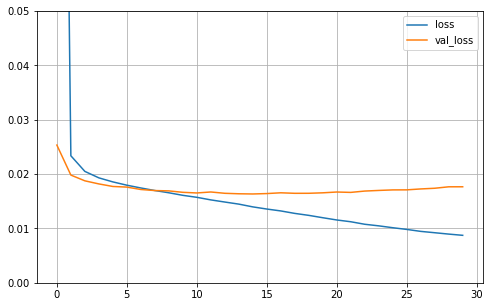

In [24]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,.05)
plt.show()

In [25]:
submission.loc[:, train_targets.columns] = 0 #set all values in submission to 0.  Will be replaced with predicted values from model

res = train_targets.copy()
res.loc[:, train_targets.columns] = 0
res = res[:2000]

test_predict = model.predict(test.values)
val_predict = model.predict(train.values[:2000])



In [26]:
submission.sample(5)
submission.loc[:, train_targets.columns] += test_predict
res.loc[:, train_targets.columns] += val_predict
#res.loc[te, train_targets.columns] += val_predict

In [27]:
print(f'OOF Metric: {metric(train_targets[:2000], res)}')


OOF Metric: 0.017663924511820785


In [ ]:
submission.loc[test['cp_type']==1, train_targets.columns] = 0
submission.to_csv('submission.csv', index=False)

In [29]:
submission.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.000024,0.000202,0.000311,0.006956,0.008194,0.000553,0.000126,0.001459,1.938416e-07,...,0.000177,0.000119,0.000848,0.000118,0.000014,0.000229,0.000115,0.002937,0.005057,0.000911
1,id_001897cda,0.000006,0.000073,0.000223,0.002237,0.002280,0.000984,0.000578,0.001174,8.322895e-04,...,0.002076,0.000021,0.000461,0.000002,0.003808,0.000453,0.000209,0.000120,0.000142,0.002199
2,id_002429b5b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,id_00276f245,0.000019,0.000053,0.001095,0.003333,0.005699,0.011899,0.001122,0.000927,2.374645e-06,...,0.000217,0.000005,0.001337,0.035584,0.004180,0.000127,0.000093,0.001290,0.000148,0.000956
4,id_0027f1083,0.000217,0.000341,0.005609,0.003286,0.005566,0.000240,0.005721,0.000775,8.110248e-07,...,0.000887,0.000019,0.004288,0.000209,0.000150,0.000375,0.000212,0.000924,0.000001,0.000710
